In [14]:
import os
import random

import torch
from torch import nn
from torchvision import datasets, models
from torchvision.transforms import v2
from torch.utils.data import DataLoader
from torchsummary import summary

import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics import confusion_matrix
from sklearn.metrics import f1_score

In [15]:
device= torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [16]:
weights= models.MNASNet1_3_Weights.DEFAULT.DEFAULT

transform= weights.transforms()
print(transform)

ImageClassification(
    crop_size=[224]
    resize_size=[232]
    mean=[0.485, 0.456, 0.406]
    std=[0.229, 0.224, 0.225]
    interpolation=InterpolationMode.BILINEAR
)


In [17]:
mean=transform.mean
std=transform.std

train_transform = v2.Compose([
    v2.ToImage(),
    v2.ToDtype(torch.float32, scale=True),
    v2.Normalize(mean=mean, std=std)
])

In [18]:
train_dataset= datasets.ImageFolder(root= r'D:\ASL_Project\augmented_dataset2', transform= train_transform)

label_map = {'rejected': 0, 'approved': 1}

train_dataset.targets = [
    label_map[train_dataset.classes[label]]
    for label in train_dataset.targets
]

train_loader= DataLoader(train_dataset, batch_size=16 , shuffle= True, num_workers= 4, pin_memory= True)

In [19]:
test_dataset= datasets.ImageFolder(root= r'D:\ASL_Project\dataset', transform= transform)

label_map = {'rejected': 0, 'approved': 1}

test_dataset.targets = [
    label_map[test_dataset.classes[label]]
    for label in test_dataset.targets
]

test_loader= DataLoader(test_dataset, batch_size=16 , shuffle= True, num_workers= 4, pin_memory= True)

In [20]:
model= models.mnasnet1_3(weights= weights)
model= model.to(device)

In [21]:
summary(model, input_size=(3, 224, 224))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 40, 112, 112]           1,080
       BatchNorm2d-2         [-1, 40, 112, 112]              80
              ReLU-3         [-1, 40, 112, 112]               0
            Conv2d-4         [-1, 40, 112, 112]             360
       BatchNorm2d-5         [-1, 40, 112, 112]              80
              ReLU-6         [-1, 40, 112, 112]               0
            Conv2d-7         [-1, 24, 112, 112]             960
       BatchNorm2d-8         [-1, 24, 112, 112]              48
            Conv2d-9         [-1, 72, 112, 112]           1,728
      BatchNorm2d-10         [-1, 72, 112, 112]             144
             ReLU-11         [-1, 72, 112, 112]               0
           Conv2d-12           [-1, 72, 56, 56]             648
      BatchNorm2d-13           [-1, 72, 56, 56]             144
             ReLU-14           [-1, 72,

In [22]:
for param in model.parameters():
    param.requires_grad = False

for param in model.classifier.parameters():
    param.requires_grad = True
    
model.classifier= nn.Linear(1280, 1)
model.to(device)

MNASNet(
  (layers): Sequential(
    (0): Conv2d(3, 40, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(40, eps=1e-05, momentum=0.00029999999999996696, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Conv2d(40, 40, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=40, bias=False)
    (4): BatchNorm2d(40, eps=1e-05, momentum=0.00029999999999996696, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): Conv2d(40, 24, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (7): BatchNorm2d(24, eps=1e-05, momentum=0.00029999999999996696, affine=True, track_running_stats=True)
    (8): Sequential(
      (0): _InvertedResidual(
        (layers): Sequential(
          (0): Conv2d(24, 72, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (1): BatchNorm2d(72, eps=1e-05, momentum=0.00029999999999996696, affine=True, track_running_stats=True)
          (2): ReLU(inplace=True)
          (3): Conv2d(72, 

In [23]:
summary(model, input_size=(3, 224, 224))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 40, 112, 112]           1,080
       BatchNorm2d-2         [-1, 40, 112, 112]              80
              ReLU-3         [-1, 40, 112, 112]               0
            Conv2d-4         [-1, 40, 112, 112]             360
       BatchNorm2d-5         [-1, 40, 112, 112]              80
              ReLU-6         [-1, 40, 112, 112]               0
            Conv2d-7         [-1, 24, 112, 112]             960
       BatchNorm2d-8         [-1, 24, 112, 112]              48
            Conv2d-9         [-1, 72, 112, 112]           1,728
      BatchNorm2d-10         [-1, 72, 112, 112]             144
             ReLU-11         [-1, 72, 112, 112]               0
           Conv2d-12           [-1, 72, 56, 56]             648
      BatchNorm2d-13           [-1, 72, 56, 56]             144
             ReLU-14           [-1, 72,

In [24]:
loss_fn= nn.BCEWithLogitsLoss()
optimizer= torch.optim.AdamW(model.parameters(), lr= 0.001)
scheduler= torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience= 3, factor= 0.5)

def training(dataloader, model, loss_fn, optimizer, scheduler=None):
    model.train()
    
    total_loss = 0
    all_preds = []
    all_labels = []

    for X, y in dataloader:
        X = X.to(device)
        y = y.float().unsqueeze(1).to(device)

        pred = model(X)
        loss = loss_fn(pred, y)  

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

        probs = torch.sigmoid(pred)
        preds = (probs > 0.5).int()

        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(y.cpu().numpy())

    avg_loss = total_loss / len(dataloader)

    all_preds = torch.tensor(all_preds).view(-1)
    all_labels = torch.tensor(all_labels).view(-1)

    accuracy = (all_preds == all_labels).float().mean().item()
    f1 = f1_score(all_labels, all_preds)

    if scheduler is not None:
        scheduler.step(avg_loss)

    print(f"Train Loss: {avg_loss:.4f} | Accuracy: {accuracy:.4f} | F1 Score: {f1:.4f}")
    


def testing(dataloader, model, loss_fn):
    model.eval()
    
    total_loss = 0
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for X, y in dataloader:
            X = X.to(device)
            y = y.float().unsqueeze(1).to(device)

            pred = model(X)         
            loss = loss_fn(pred, y) 

            total_loss += loss.item()


            probs = torch.sigmoid(pred)
            preds = (probs > 0.5).int()

            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(y.cpu().numpy())

    avg_loss = total_loss / len(dataloader)

    all_preds = torch.tensor(all_preds).view(-1)
    all_labels = torch.tensor(all_labels).view(-1)

    accuracy = (all_preds == all_labels).float().mean().item()
    f1 = f1_score(all_labels, all_preds)

    print(f"Test Loss: {avg_loss:.4f} | Accuracy: {accuracy:.4f} | F1: {f1:.4f}")

In [25]:
n_epochs=40

for epoch in range(1,n_epochs+1):
    print(f"Epoch {epoch}/{n_epochs}:")
    print("-"*50)
    training(train_loader, model, loss_fn, optimizer, scheduler)
    print("-"*50)
    testing(test_loader, model, loss_fn)
    print("-"*50)
    print("\n")

Epoch 1/40:
--------------------------------------------------
Train Loss: 0.3594 | Accuracy: 0.8477 | F1 Score: 0.6465
--------------------------------------------------
Test Loss: 0.5407 | Accuracy: 0.7546 | F1: 0.1681
--------------------------------------------------


Epoch 2/40:
--------------------------------------------------
Train Loss: 0.2274 | Accuracy: 0.9217 | F1 Score: 0.8454
--------------------------------------------------
Test Loss: 0.3557 | Accuracy: 0.8420 | F1: 0.5870
--------------------------------------------------


Epoch 3/40:
--------------------------------------------------
Train Loss: 0.1971 | Accuracy: 0.9256 | F1 Score: 0.8588
--------------------------------------------------
Test Loss: 0.5689 | Accuracy: 0.8016 | F1: 0.4198
--------------------------------------------------


Epoch 4/40:
--------------------------------------------------
Train Loss: 0.1750 | Accuracy: 0.9339 | F1 Score: 0.8742
--------------------------------------------------
Test Lo

Confusion Matrix:
[[558   1]
 [ 54 153]]


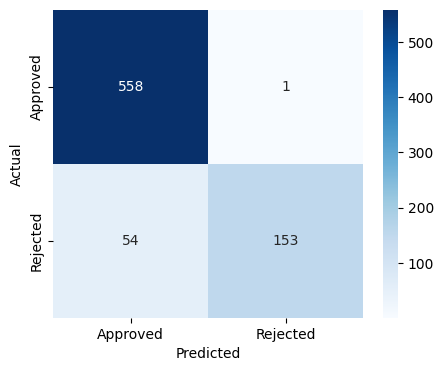

In [26]:
def print_confusion_matrix(dataloader, model):
    model.eval()
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for X, y in dataloader:
            X = X.to(device)
            y = y.float().to(device)

            pred = model(X)                 
            probs = torch.sigmoid(pred)     
            preds = (probs > 0.5).int()    

            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(y.cpu().numpy())

    
    all_preds = np.array(all_preds).reshape(-1)
    all_labels = np.array(all_labels).reshape(-1)

    cm = confusion_matrix(all_labels, all_preds)
    print("Confusion Matrix:")
    print(cm)

    # Optional: pretty heatmap
    plt.figure(figsize=(5,4))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=['Approved','Rejected'],
                yticklabels=['Approved','Rejected'])
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.show()
    
print_confusion_matrix(test_loader, model)